# Análise Fatorial PCA

# Modelagem de empréstimo bancário
Este caso envolve o banco TC Bank (nome fictício), que possui uma crescente base de clientes. A maioria deles são depositantes com diferentes montantes de depósitos. O número de clientes que também são tomadores de empréstimo é pequeno, e o banco deseja aumentar rapidamente essa base para impulsionar os negócios de empréstimo e obter mais lucros com os juros. A gerência quer explorar maneiras de converter depositantes em tomadores de empréstimo pessoal, mantendo-os como depositantes. Uma campanha realizada no ano passado para depositantes resultou em uma taxa de conversão superior a 9%. Esse resultado incentivou o departamento de marketing a planejar campanhas para direcionar melhor o marketing e aumentar a taxa de sucesso com um orçamento mínimo. O departamento pretende construir um modelo para identificar clientes em potencial com maior probabilidade de adquirir empréstimos, aumentando a taxa de sucesso e reduzindo o custo da campanha.

#### Instalando os pacotes

In [1]:
!pip install pandas
!pip install numpy
!pip install factor_analyzer
!pip install sympy
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install plotly
!pip install pingouin
!pip install pyshp

#### Importando os pacotes necessários

In [3]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
pio.renderers.default = 'browser'
import plotly.graph_objects as go
import sympy as sy
import scipy as sp

#### Importando o banco de dados

In [4]:
emprestimo = pd.read_excel("emprestimo_banco.xlsx")
# Fonte: adaptado de https://www.kaggle.com/datasets/itsmesunil/bank-loan-modelling
'''
 Family: Family size of the customer
 CCAvg: Avg. spending on credit cards per month ($000)
 Mortgage (Ipoteca): Value of house mortgage if any
 Experience: number of years of professional experience
 Income: Annual income of the customer ($000)
'''

## TODAS DAS VARIÁVEIS DE INTERESSE SÃO MÉTRICAS. PORTANTO, PODEMOS PROSSEGUIR

'\n Family: Family size of the customer\n CCAvg: Avg. spending on credit cards per month ($000)\n Mortgage (Ipoteca): Value of house mortgage if any\n Experience: number of years of professional experience\n Income: Annual income of the customer ($000)\n'

#### Separando somente as variáveis para a análise fatorial PCA

In [7]:
emprestimo_pca = emprestimo.drop(columns=['ID'])
print(emprestimo_pca)

      Age  Experience  Income  Family  CCAvg  Mortgage
0      25           1      49       4    1.6         0
1      45          19      34       3    1.5         0
2      39          15      11       1    1.0         0
3      35           9     100       1    2.7         0
4      35           8      45       4    1.0         0
...   ...         ...     ...     ...    ...       ...
4995   29           3      40       1    1.9         0
4996   30           4      15       4    0.4        85
4997   63          39      24       2    0.3         0
4998   65          40      49       3    0.5         0
4999   28           4      83       3    0.8         0

[5000 rows x 6 columns]


#### Estatísticas descritivas das variáveis

In [9]:
tab_desc = emprestimo_pca.describe()
print(tab_desc)

               Age   Experience       Income       Family        CCAvg  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean     45.338400    20.119600    73.774200     2.396400     1.937913   
std      11.463166    11.440484    46.033729     1.147663     1.747666   
min      23.000000     0.000000     8.000000     1.000000     0.000000   
25%      35.000000    10.000000    39.000000     1.000000     0.700000   
50%      45.000000    20.000000    64.000000     2.000000     1.500000   
75%      55.000000    30.000000    98.000000     3.000000     2.500000   
max      67.000000    43.000000   224.000000     4.000000    10.000000   

          Mortgage  
count  5000.000000  
mean     56.498800  
std     101.713802  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%     101.000000  
max     635.000000  


#### Matriz de correlações de Pearson

In [10]:
# Matriz de correlações em um objeto "simples"

corr = emprestimo_pca.corr()

# Gráfico interativo

fig = go.Figure()

fig.add_trace(
    go.Heatmap(
        x = corr.columns,
        y = corr.index,
        z = np.array(corr),
        text=corr.values,
        texttemplate='%{text:.3f}',
        colorscale='viridis'))

fig.update_layout(
    height = 600,
    width = 600,
    yaxis=dict(autorange="reversed"))

fig.show()

#### Teste de Esfericidade de Bartlett

In [11]:
bartlett, p_value = calculate_bartlett_sphericity(emprestimo_pca)

print(f'Qui² Bartlett: {round(bartlett, 2)}')
print(f'p-valor: {round(p_value, 4)}')

Qui² Bartlett: 25409.78
p-valor: 0.0


#### Definindo a PCA (procedimento inicial com todos os fatores possíveis)

In [12]:
fa = FactorAnalyzer(n_factors=6, method='principal', rotation=None).fit(emprestimo_pca)

#### Obtendo os eigenvalues (autovalores): resultantes da função FactorAnalyzer

In [15]:
autovalores = fa.get_eigenvalues()[0]

print(autovalores)

# Soma dos autovalores

round(autovalores.sum(), 2) # A soma dos AUTOVALORES tem que ser igual ao total de variáveis originais. Mas se aplicarmos o Critério de Kaiser (raiz latente) e selecionarmos alguns autovalores, então a soma total dos AUTOVALORES não será igual ao total de variáveis originais.

[2.02800719 1.73665956 0.97645432 0.90872121 0.34441264 0.00574507]


6.0

#### Redefinindo a PCA pelo critério da raiz latente

In [16]:
# Há dois fatores derivados de autovalores > 1

fa = FactorAnalyzer(n_factors=2, method='principal', rotation=None).fit(emprestimo_pca)

#### Eigenvalues, variâncias e variâncias acumuladas

In [17]:
autovalores_fatores = fa.get_factor_variance() ## "get_factor_variance" traz "Eigenvalues", "variâncias" e "variâncias acumuladas"

tabela_eigen = pd.DataFrame(autovalores_fatores)
tabela_eigen.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_eigen.columns)]
tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
tabela_eigen = tabela_eigen.T

print(tabela_eigen)
# Ao todo, 0.627444 (62%) da variância das variáveis originais estão representados nesses fatores extraídos.

         Autovalor  Variância  Variância Acumulada
Fator 1   2.028007   0.338001             0.338001
Fator 2   1.736660   0.289443             0.627444


#### Determinando as cargas fatoriais

In [18]:
cargas_fatoriais = fa.loadings_ # Os loadings_ são as cargas fatoriais

tabela_cargas = pd.DataFrame(cargas_fatoriais)
tabela_cargas.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_cargas.columns)]
tabela_cargas.index = emprestimo_pca.columns

print(tabela_cargas)

             Fator 1   Fator 2
Age         0.959012  0.271073
Experience  0.957367  0.277678
Income     -0.301979  0.837176
Family     -0.011960 -0.344334
CCAvg      -0.295701  0.800263
Mortgage   -0.113918  0.355280


#### Gráfico das cargas fatoriais (loading plot)

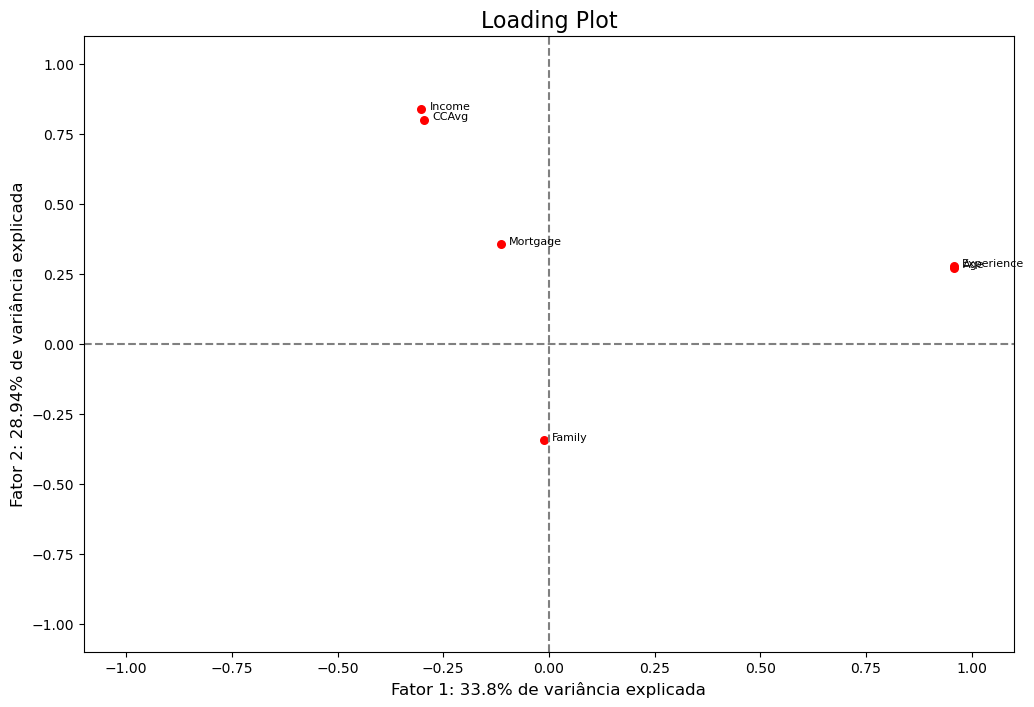

In [19]:
plt.figure(figsize=(12,8))
tabela_cargas_chart = tabela_cargas.reset_index()
plt.scatter(tabela_cargas_chart['Fator 1'], tabela_cargas_chart['Fator 2'], s=30, color='red')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.02, point['y'], point['val'], fontsize=8)

label_point(x = tabela_cargas_chart['Fator 1'],
            y = tabela_cargas_chart['Fator 2'],
            val = tabela_cargas_chart['index'],
            ax = plt.gca()) 

plt.axhline(y=0, color='grey', ls='--')
plt.axvline(x=0, color='grey', ls='--')
plt.ylim([-1.1,1.1])
plt.xlim([-1.1,1.1])
plt.title("Loading Plot", fontsize=16)
plt.xlabel(f"Fator 1: {round(tabela_eigen.iloc[0]['Variância']*100,2)}% de variância explicada", fontsize=12)
plt.ylabel(f"Fator 2: {round(tabela_eigen.iloc[1]['Variância']*100,2)}% de variância explicada", fontsize=12)
plt.show()

#### Determinando as comunalidades

In [20]:
comunalidades = fa.get_communalities()

tabela_comunalidades = pd.DataFrame(comunalidades)
tabela_comunalidades.columns = ['Comunalidades']
tabela_comunalidades.index = emprestimo_pca.columns

print(tabela_comunalidades)

            Comunalidades
Age              0.993184
Experience       0.993658
Income           0.792054
Family           0.118709
CCAvg            0.727860
Mortgage         0.139201


#### Extração dos fatores para as observações do banco de dados

In [21]:
fatores = pd.DataFrame(fa.transform(emprestimo_pca)) # "fa.transform(casas_pca)" calcula Fatores. A padronização (ZCORE) é feito internamente.
fatores.columns =  [f"Fator {i+1}" for i, v in enumerate(fatores.columns)]

#### Identificando os scores fatoriais

In [22]:
scores = fa.weights_ ## CRIA TABELA SEM FORMATAÇÃO

tabela_scores = pd.DataFrame(scores)
tabela_scores.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_scores.columns)]
tabela_scores.index = emprestimo_pca.columns

print(tabela_scores)

             Fator 1   Fator 2
Age         0.472884  0.156089
Experience  0.472073  0.159892
Income     -0.148904  0.482061
Family     -0.005898 -0.198274
CCAvg      -0.145809  0.460806
Mortgage   -0.056173  0.204577


#### Em certos casos, a "rotação de fatores" pode melhorar a interpretação
######  Analisando pelo loading plot, aplica-se a rotação dos eixos na origem (0,0)
######  O método mais comum é a 'varimax', que é a rotação ortogonal dos fatores
######  O objetivo é aumentar a carga fatorial em um fator e diminuir em outro
######  Em resumo, trata-se de uma redistribuição de cargas fatoriais

#### Adicionando a rotação: rotation='varimax'

In [23]:
# Aplicando a rotação aos 2 fatores extraídos

fa = FactorAnalyzer(n_factors=2, method='principal', rotation='varimax').fit(emprestimo_pca)
### QUANDO O NOSSO INTERESSE FOR DE "Aplicar a rotação aos fatores extraídos", aí sim colocamos o método "varimax" no lugar de None. Mas há outros métodos que podem ser aplicados.

#### Eigenvalues, variâncias e variâncias acumuladas

In [24]:
autovalores_fatores = fa.get_factor_variance()

tabela_eigen = pd.DataFrame(autovalores_fatores)
tabela_eigen.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_eigen.columns)]
tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
tabela_eigen = tabela_eigen.T

print(tabela_eigen)

         Autovalor  Variância  Variância Acumulada
Fator 1   2.007323   0.334554             0.334554
Fator 2   1.757344   0.292891             0.627444


#### Determinando as cargas fatoriais

In [25]:
cargas_fatoriais = fa.loadings_

tabela_cargas = pd.DataFrame(cargas_fatoriais)
tabela_cargas.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_cargas.columns)]
tabela_cargas.index = emprestimo_pca.columns

print(tabela_cargas)

             Fator 1   Fator 2
Age         0.996570  0.005748
Experience  0.996745  0.012552
Income     -0.067999  0.887373
Family     -0.103275 -0.328699
CCAvg      -0.071784  0.850122
Mortgage   -0.015137  0.372790


#### Gráfico das cargas fatoriais (loading plot)

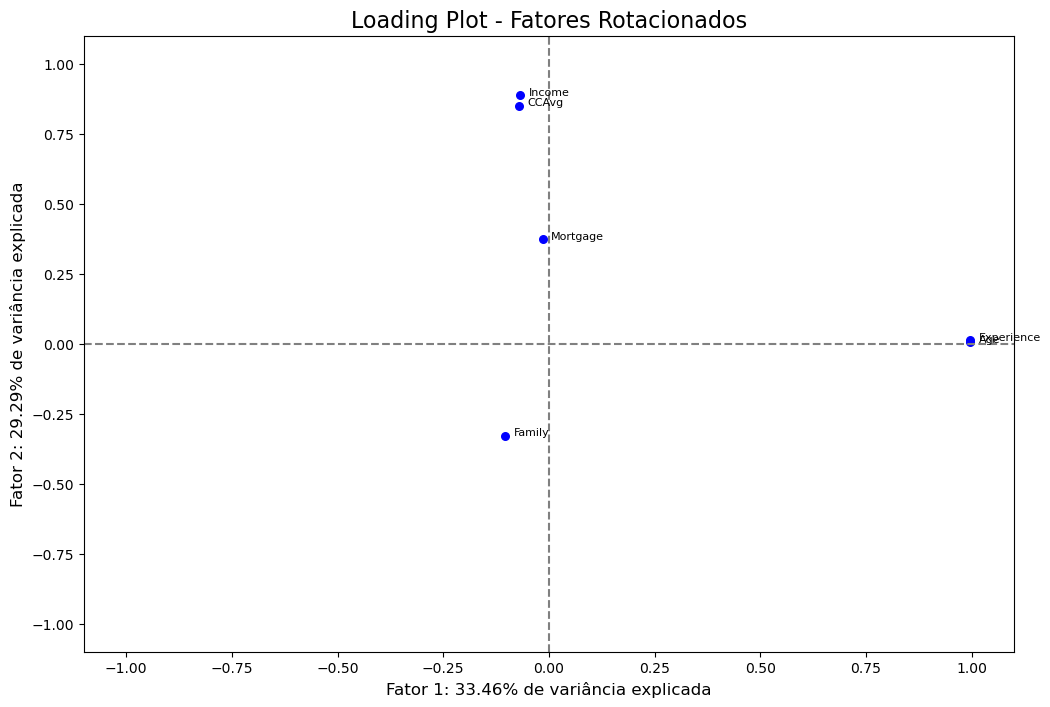

In [26]:
plt.figure(figsize=(12,8))
tabela_cargas_chart = tabela_cargas.reset_index()
plt.scatter(tabela_cargas_chart['Fator 1'], tabela_cargas_chart['Fator 2'], s=30, color='blue')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.02, point['y'], point['val'], fontsize=8)

label_point(x = tabela_cargas_chart['Fator 1'],
            y = tabela_cargas_chart['Fator 2'],
            val = tabela_cargas_chart['index'],
            ax = plt.gca()) 

plt.axhline(y=0, color='grey', ls='--')
plt.axvline(x=0, color='grey', ls='--')
plt.ylim([-1.1,1.1])
plt.xlim([-1.1,1.1])
plt.title("Loading Plot - Fatores Rotacionados", fontsize=16)
plt.xlabel(f"Fator 1: {round(tabela_eigen.iloc[0]['Variância']*100,2)}% de variância explicada", fontsize=12)
plt.ylabel(f"Fator 2: {round(tabela_eigen.iloc[1]['Variância']*100,2)}% de variância explicada", fontsize=12)
plt.show()

#### Determinando as comunalidades

In [27]:
comunalidades = fa.get_communalities()

tabela_comunalidades = pd.DataFrame(comunalidades)
tabela_comunalidades.columns = ['Comunalidades']
tabela_comunalidades.index = emprestimo_pca.columns

print(tabela_comunalidades)

            Comunalidades
Age              0.993184
Experience       0.993658
Income           0.792054
Family           0.118709
CCAvg            0.727860
Mortgage         0.139201


#### Extração dos fatores para as observações do banco de dados

In [28]:
fatores = pd.DataFrame(fa.transform(emprestimo_pca)) # A padronização (ZCORE) é feito internamente.
fatores.columns =  [f"Fator {i+1}" for i, v in enumerate(fatores.columns)]

# Adicionando os fatores ao banco de dados

emprestimo = pd.concat([emprestimo.reset_index(drop=True), fatores], axis=1)

#### Identificando os scores fatoriais

In [29]:
scores = fa.weights_

tabela_scores = pd.DataFrame(scores)
tabela_scores.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_scores.columns)]
tabela_scores.index = emprestimo_pca.columns

print(tabela_scores)

             Fator 1   Fator 2
Age         0.497378  0.024448
Experience  0.497610  0.028330
Income     -0.015077  0.504309
Family     -0.058514 -0.189535
CCAvg      -0.017757  0.482998
Mortgage    0.000367  0.212148


#### Interpretando os scores fatoriais em cada fator extraído

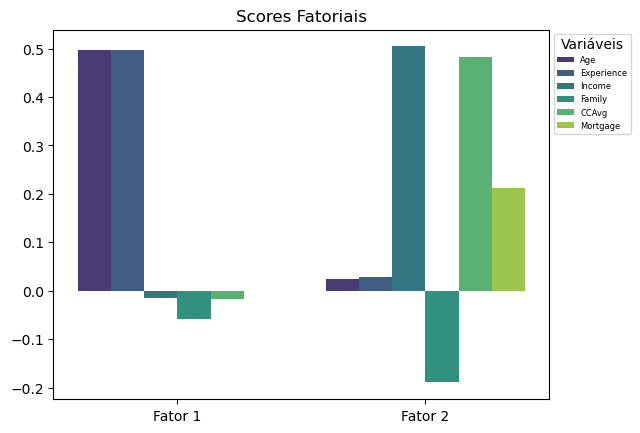

In [30]:
tabela_scores_graph = tabela_scores.reset_index()
tabela_scores_graph = tabela_scores_graph.melt(id_vars='index')

sns.barplot(data=tabela_scores_graph, x='variable', y='value', hue='index', palette='viridis')
plt.legend(title='Variáveis', bbox_to_anchor=(1,1), fontsize = '6')
plt.title('Scores Fatoriais', fontsize='12')
plt.xlabel(xlabel=None)
plt.ylabel(ylabel=None)
plt.show()

#### Os fatores continuam ortogonais

In [31]:
pg.rcorr(emprestimo[['Fator 1', 'Fator 2']], 
         method = 'pearson', upper = 'pval', 
         decimals = 4, 
         pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})

C:\Users\Khomp\USPesalqMBA\Lib\site-packages\pingouin\correlation.py:1116: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,Fator 1,Fator 2
Fator 1,-,
Fator 2,0.0,-


In [ ]:
# FIM!